# LP for Solving MDPs

We can formulate the LP in the following way:

## Imports

In [1]:
import cvxpy as cp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

## Code

In [2]:
def recycling_robot(alpha, beta, r_s=2, r_w=1, gamma=0.9):
    """
    Solves the recycling robot problem using CVXPY.

    Parameters:
        alpha: Probability of staying in high state when searching.
        beta: Probability of staying in low state when searching.
        r_s: Expected reward for searching (if battery doesn't die).
        r_w: Expected reward for waiting.
        gamma: Discount factor (default: 0.9).

    Returns:
        {"v_h": v_h, "v_l": v_l, "pi_h": pi_h, "pi_l": pi_l}
    Where pi_h and pi_l are optimal policies. 0 is recharge, 1 is wait and 2 is search.
    """
    # Decision variables
    v_h = cp.Variable(name="v_h")  # Value for high state
    v_l = cp.Variable(name="v_l")  # Value for low state

    # Objective
    objective = cp.Minimize(v_h) # we can also use v_h + v_l

    # Constraints (Bellman)
    constraints = [
        v_h >= r_w + gamma * v_h, # high -> wait
        v_h >= r_s + gamma * (alpha * v_h + (1 - alpha) * v_l), # high -> search
        v_l >= r_w + gamma * v_l, # low -> wait
        v_l >= gamma * v_h, # low -> recharge
        v_l >= beta * r_s - 3 * (1 - beta) + gamma * ((1 - beta) * v_h + beta * v_l) # low -> search
    ]

    # Solve the problem using a linear programming solver
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.GLPK)  # Use GLPK, an LP solver

    # Convert to float
    v_h = float(v_h.value)
    v_l = float(v_l.value)

    # Calculating optimal policies
    pi_h = -1
    pi_l = -1

    eps = 0.001

    if abs(v_h - (r_w + gamma * v_h)) < eps:
      pi_h = 1 # wait
    elif abs( v_h - (r_s + gamma * (alpha * v_h + (1 - alpha) * v_l))) < eps:
      pi_h = 2 # search

    if abs( v_l - (r_w + gamma * v_l)) < eps:
      pi_l = 1 # wait
    elif abs(v_l - (gamma * v_h)) < eps:
      pi_l = 0 # recharge
    elif abs(v_l - (beta * r_s - 3 * (1 - beta) + gamma * ((1 - beta) * v_h + beta * v_l))) < eps:
      pi_l = 2 # search

    return {
        "v_h": v_h,
        "v_l": v_l,
        "pi_h": pi_h,
        "pi_l": pi_l
    }

## Experiments

In [3]:
# Generate a grid of alpha and beta values
alpha_vals = np.linspace(0.01, 0.99, 50)
beta_vals = np.linspace(0.01, 0.99, 50)

# Prepare empty arrays to store results
v_h_values = np.zeros((len(alpha_vals), len(beta_vals)))
v_l_values = np.zeros((len(alpha_vals), len(beta_vals)))
pi_h_values = np.zeros((len(alpha_vals), len(beta_vals)))
pi_l_values = np.zeros((len(alpha_vals), len(beta_vals)))

# Run the recycling_robot function on the grid of alpha and beta
for i, alpha in enumerate(alpha_vals):
    for j, beta in enumerate(beta_vals):
        result = recycling_robot(alpha, beta)
        v_h_values[i, j] = result["v_h"]
        v_l_values[i, j] = result["v_l"]
        pi_h_values[i, j] = result["pi_h"]
        pi_l_values[i, j] = result["pi_l"]

# Create a grid for alpha and beta values
alpha_grid, beta_grid = np.meshgrid(alpha_vals, beta_vals)

# Flatten the grid for scatter plotting
alpha_flat = alpha_grid.flatten()
beta_flat = beta_grid.flatten()




## Plot

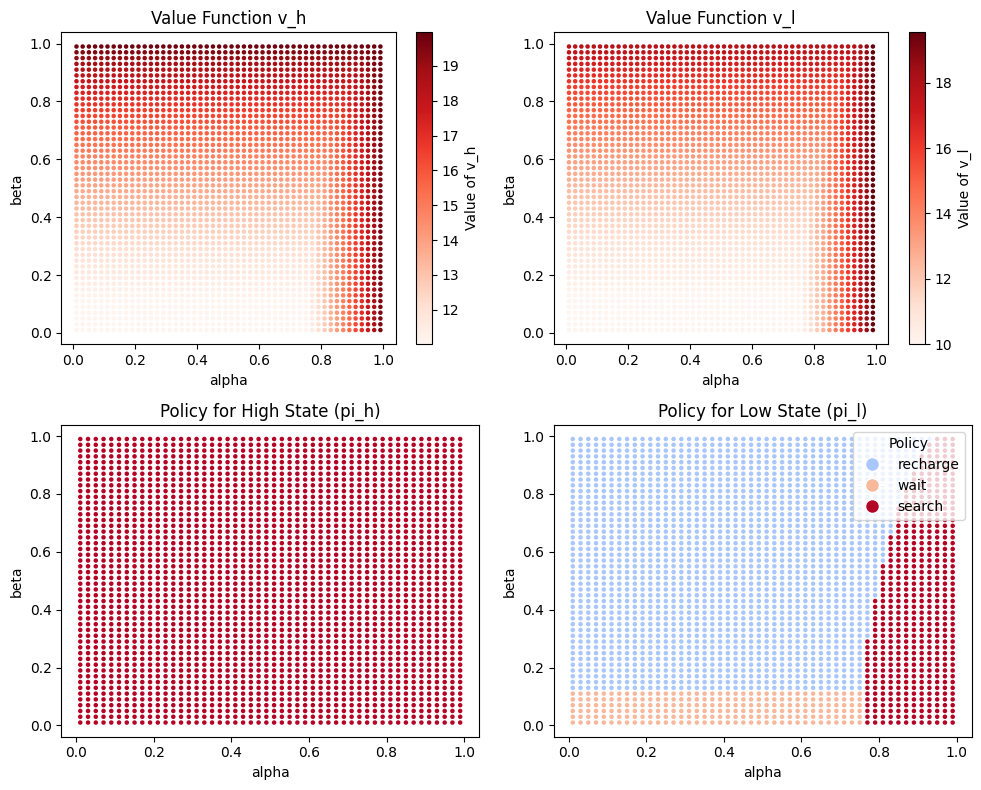

In [4]:
# Plot the scatter plots
plt.figure(figsize=(10, 8))

# Scatter plot for v_h
plt.subplot(2, 2, 1)
plt.scatter(alpha_flat, beta_flat, c=v_h_values.flatten(), cmap='Reds', s=5)
plt.colorbar(label='Value of v_h')
plt.title("Value Function v_h")
plt.xlabel("alpha")
plt.ylabel("beta")

# Scatter plot for v_l
plt.subplot(2, 2, 2)
plt.scatter(alpha_flat, beta_flat, c=v_l_values.flatten(), cmap='Reds', s=5)
plt.colorbar(label='Value of v_l')
plt.title("Value Function v_l")
plt.xlabel("alpha")
plt.ylabel("beta")

# Scatter plot for pi_h
plt.subplot(2, 2, 3)
scatter_h = plt.scatter(alpha_flat, beta_flat, c=pi_h_values.flatten(), cmap='coolwarm', s=5, vmin=-1, vmax=2)
plt.title("Policy for High State (pi_h)")
plt.xlabel("alpha")
plt.ylabel("beta")

# Scatter plot for pi_l
plt.subplot(2, 2, 4)
scatter_l = plt.scatter(alpha_flat, beta_flat, c=pi_l_values.flatten(), cmap='coolwarm', s=5, vmin=-1, vmax=2)
plt.title("Policy for Low State (pi_l)")
plt.xlabel("alpha")
plt.ylabel("beta")

# Creating custom legends for the values
legend_labels = ['recharge', 'wait', 'search']
legend_colors = [scatter_h.cmap(scatter_h.norm(val)) for val in [0, 1, 2]]

# Add custom legends
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in zip(legend_labels, legend_colors)]
plt.legend(handles=handles, title="Policy")

plt.tight_layout()
plt.show()